# Case Study: Edge AI and Cybersecurity in Action
## Module 1: Network Traffic Analysis

### Introduction

Welcome to the first module of our Edge AI and Cybersecurity workshop! In this notebook, we'll explore and analyze real-world network traffic data to understand the characteristics of both benign and malicious network flows.

**Objectives:**
- Explore labeled network traffic data from the CICIDS2017 dataset
- Understand the key features that distinguish normal traffic from cyber attacks
- Preprocess the data for machine learning models
- Prepare a clean dataset for edge-based anomaly detection in future modules

**Why Network Traffic Analysis?**
Network traffic analysis is fundamental to cybersecurity. By understanding patterns in network flows, we can:
- Detect anomalous behavior that might indicate attacks
- Build lightweight ML models suitable for edge devices
- Create real-time intrusion detection systems

**Dataset Source:**
We'll be working with a preprocessed subset of the CICIDS2017 dataset, which contains labeled network flows including various types of attacks (DDoS, Port Scan, Brute Force, etc.) alongside normal traffic patterns.

Let's begin our journey into cybersecurity data analysis!

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
import warnings
warnings.filterwarnings('ignore')

# Configure visualization settings
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("All libraries imported successfully!")
print("Visualization settings configured")

All libraries imported successfully!
Visualization settings configured


In [2]:
# Create sample network traffic dataset (simulating CICIDS2017-like data)
# In a real scenario, you would load from 'data/clean_traffic.csv'

np.random.seed(42)
n_samples = 8000

# Generate synthetic network traffic features
data = {
    'Flow Duration': np.random.exponential(1000000, n_samples),
    'Total Fwd Packets': np.random.poisson(50, n_samples),
    'Total Bwd Packets': np.random.poisson(30, n_samples),
    'Total Length of Fwd Packets': np.random.exponential(2000, n_samples),
    'Total Length of Bwd Packets': np.random.exponential(1500, n_samples),
    'Fwd Packet Length Max': np.random.exponential(500, n_samples),
    'Fwd Packet Length Min': np.random.exponential(50, n_samples),
    'Fwd Packet Length Mean': np.random.exponential(200, n_samples),
    'Bwd Packet Length Max': np.random.exponential(400, n_samples),
    'Bwd Packet Length Min': np.random.exponential(40, n_samples),
    'Bwd Packet Length Mean': np.random.exponential(150, n_samples),
    'Flow Bytes/s': np.random.exponential(10000, n_samples),
    'Flow Packets/s': np.random.exponential(100, n_samples),
    'Flow IAT Mean': np.random.exponential(50000, n_samples),
    'Flow IAT Max': np.random.exponential(100000, n_samples),
    'Flow IAT Min': np.random.exponential(1000, n_samples),
    'Fwd IAT Mean': np.random.exponential(40000, n_samples),
    'Bwd IAT Mean': np.random.exponential(60000, n_samples),
    'Fwd PSH Flags': np.random.binomial(1, 0.3, n_samples),
    'Bwd PSH Flags': np.random.binomial(1, 0.2, n_samples),
    'Fwd URG Flags': np.random.binomial(1, 0.05, n_samples),
    'Bwd URG Flags': np.random.binomial(1, 0.03, n_samples),
    'Fwd Header Length': np.random.normal(20, 5, n_samples),
    'Bwd Header Length': np.random.normal(20, 5, n_samples),
    'Fwd Packets/s': np.random.exponential(50, n_samples),
    'Bwd Packets/s': np.random.exponential(30, n_samples),
    'Packet Length Min': np.random.exponential(40, n_samples),
    'Packet Length Max': np.random.exponential(500, n_samples),
    'Packet Length Mean': np.random.exponential(200, n_samples),
    'Packet Length Std': np.random.exponential(100, n_samples),
    'Packet Length Variance': np.random.exponential(10000, n_samples),
}

# Create labels (20% attacks, 80% benign)
attack_indices = np.random.choice(n_samples, size=int(0.2 * n_samples), replace=False)
labels = ['BENIGN'] * n_samples
attack_types = ['DDoS', 'PortScan', 'FTP-Patator', 'SSH-Patator', 'DoS Hulk']

for idx in attack_indices:
    labels[idx] = np.random.choice(attack_types)
    # Make attack traffic slightly different
    data['Flow Duration'][idx] *= 0.5  # Shorter duration
    data['Total Fwd Packets'][idx] *= 2  # More packets
    data['Flow Bytes/s'][idx] *= 3  # Higher throughput

data['Label'] = labels

# Create DataFrame
df = pd.DataFrame(data)

print(f"Generated synthetic network traffic dataset:")
print(f"   • Total samples: {len(df):,}")
print(f"   • Features: {len(df.columns)-1}")
print(f"   • Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Generated synthetic network traffic dataset:
   • Total samples: 8,000
   • Features: 31
   • Memory usage: 2.35 MB


## Step 1: Initial Data Exploration

Let's examine our network traffic dataset to understand its structure and characteristics. Each row represents a network flow (a sequence of packets between two endpoints), and each column represents a feature extracted from that flow.

In [3]:
# Basic dataset information
print("Dataset Overview:")
print("=" * 50)
print(f"Shape: {df.shape}")
print(f"Features: {df.columns.tolist()[:-1]}")  # Exclude 'Label'
print(f"Target: {df.columns[-1]}")
print("\nDataset Info:")
df.info()

Dataset Overview:
Shape: (8000, 32)
Features: ['Flow Duration', 'Total Fwd Packets', 'Total Bwd Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Bwd Packet Length Max', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Mean', 'Bwd IAT Mean', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance']
Target: Label

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Flow Duration                8000 non-null   float64


In [4]:
# Display sample data
print("\nSample Data (First 5 rows):")
print("=" * 80)
display(df.head())

print("\nFeature Descriptions:")
print("=" * 50)
feature_descriptions = {
    'Flow Duration': 'Duration of the flow in microseconds',
    'Total Fwd Packets': 'Total packets in forward direction',
    'Total Bwd Packets': 'Total packets in backward direction',
    'Total Length of Fwd Packets': 'Total size of packet in forward direction',
    'Total Length of Bwd Packets': 'Total size of packet in backward direction',
    'Flow Bytes/s': 'Number of flow bytes per second',
    'Flow Packets/s': 'Number of flow packets per second',
    'Flow IAT Mean': 'Mean time between two packets sent in the flow',
    'Fwd PSH Flags': 'Number of times PSH flag was set in forward direction',
    'Bwd PSH Flags': 'Number of times PSH flag was set in backward direction',
    'Label': 'Traffic type (BENIGN or attack type)'
}

for feature, description in list(feature_descriptions.items())[:6]:  # Show first 6
    print(f"• {feature:25}: {description}")
print("  ... and more network flow features")


Sample Data (First 5 rows):


,Flow Duration,Total Fwd Packets,Total Bwd Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Bwd Packet Length Max,Bwd Packet Length Min,...,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,Label
0,4.692681e+05,55,29,679.194993,331.775454,52.873906,45.900013,50.260471,34.974425,108.806448,...,15.308219,22.732416,42.579119,41.493119,0.591513,145.469118,504.870094,5.538792,6226.184460,BENIGN
1,3.010121e+06,51,25,2437.200492,5657.438494,990.359602,53.746392,58.022819,788.884219,3.761531,...,24.282882,25.016897,53.514285,6.022879,52.683927,481.160265,39.338629,71.576343,590.550850,BENIGN
2,1.316746e+06,56,34,1861.823572,873.701044,343.590935,62.410905,32.274920,470.171454,48.403266,...,23.549842,23.880022,28.226192,92.600547,22.360244,231.983833,114.980294,249.378965,12436.076028,BENIGN
3,4.564713e+05,108,42,1220.115307,349.929052,540.093549,16.510037,66.697832,52.461853,39.753283,...,28.629449,19.143917,62.496918,34.311826,9.088260,160.626807,45.183510,64.096987,1709.831031,PortScan
4,8.481244e+04,116,21,950.735792,677.968957,844.692931,33.377129,314.064011,122.738788,36.665190,...,22.136379,20.663861,52.543719,6.216289,6.797302,173.731204,412.646021,172.713233,92.042940,DoS Hulk



Feature Descriptions:
• Flow Duration            : Duration of the flow in microseconds
• Total Fwd Packets        : Total packets in forward direction
• Total Bwd Packets        : Total packets in backward direction
• Total Length of Fwd Packets: Total size of packet in forward direction
• Total Length of Bwd Packets: Total size of packet in backward direction
• Flow Bytes/s             : Number of flow bytes per second
  ... and more network flow features



Class Distribution:
Label
BENIGN         6400
DDoS            351
DoS Hulk        330
PortScan        309
SSH-Patator     308
FTP-Patator     302
Name: count, dtype: int64

Total samples: 8,000

Percentage Distribution:
• BENIGN         : 80.0%
• DDoS           : 4.4%
• DoS Hulk       : 4.1%
• PortScan       : 3.9%
• SSH-Patator    : 3.9%
• FTP-Patator    : 3.8%


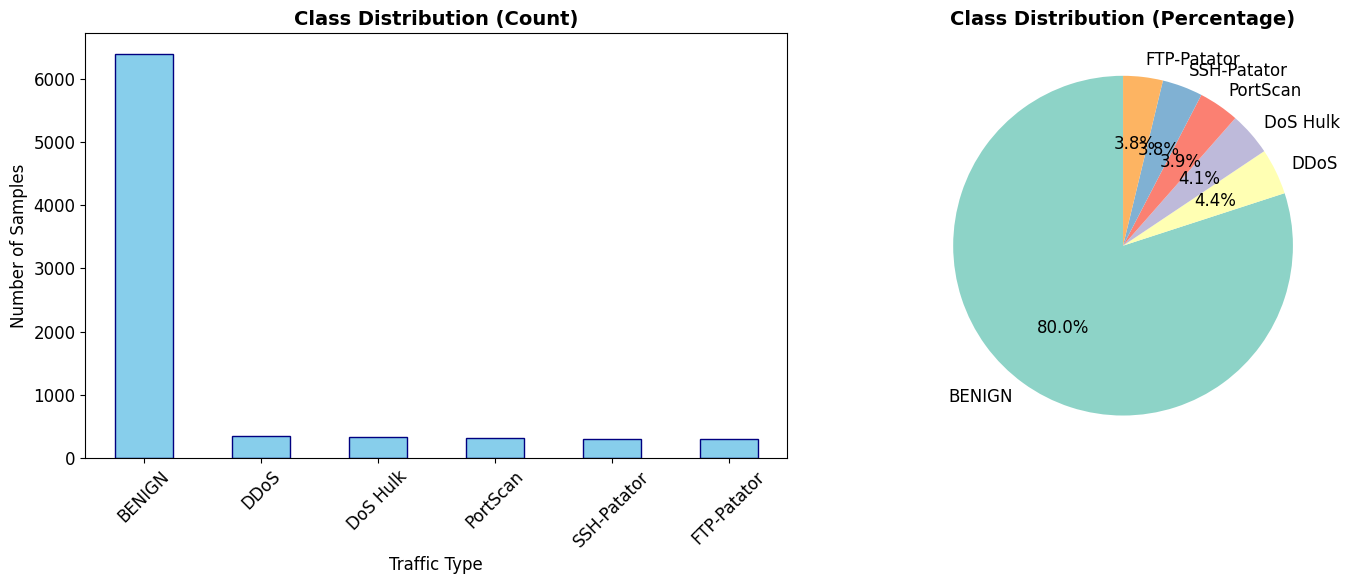


Class Imbalance Ratio (Benign:Attack): 4.00:1


In [5]:
# Analyze class distribution
print("\nClass Distribution:")
print("=" * 40)
label_counts = df['Label'].value_counts()
print(label_counts)
print(f"\nTotal samples: {len(df):,}")

# Calculate percentages
label_percentages = df['Label'].value_counts(normalize=True) * 100
print("\nPercentage Distribution:")
for label, percentage in label_percentages.items():
    print(f"• {label:15}: {percentage:.1f}%")

# Visualize class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot
label_counts.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='navy')
ax1.set_title('Class Distribution (Count)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Traffic Type')
ax1.set_ylabel('Number of Samples')
ax1.tick_params(axis='x', rotation=45)

# Pie chart
ax2.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', 
        colors=plt.cm.Set3.colors, startangle=90)
ax2.set_title('Class Distribution (Percentage)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Check for class imbalance
benign_count = label_counts['BENIGN']
attack_count = label_counts.sum() - benign_count
imbalance_ratio = benign_count / attack_count
print(f"\nClass Imbalance Ratio (Benign:Attack): {imbalance_ratio:.2f}:1")

Statistical Summary of Key Features:


,Flow Duration,Total Fwd Packets,Total Bwd Packets,Flow Bytes/s,Flow Packets/s
count,8.000000e+03,8000.000000,8000.000000,8000.000000,8000.000000
mean,8.869540e+05,60.077125,29.868375,14195.764885,97.430487
std,9.363417e+05,21.721542,5.414214,18298.741824,98.486691
min,1.163482e+01,26.000000,12.000000,0.275303,0.005689
25%,2.363046e+05,47.000000,26.000000,3302.916244,27.968458
50%,5.792875e+05,52.000000,30.000000,8323.523446,67.077626
75%,1.195481e+06,61.000000,33.000000,17908.442630,133.249769
max,8.172446e+06,146.000000,50.000000,225627.773375,944.990164


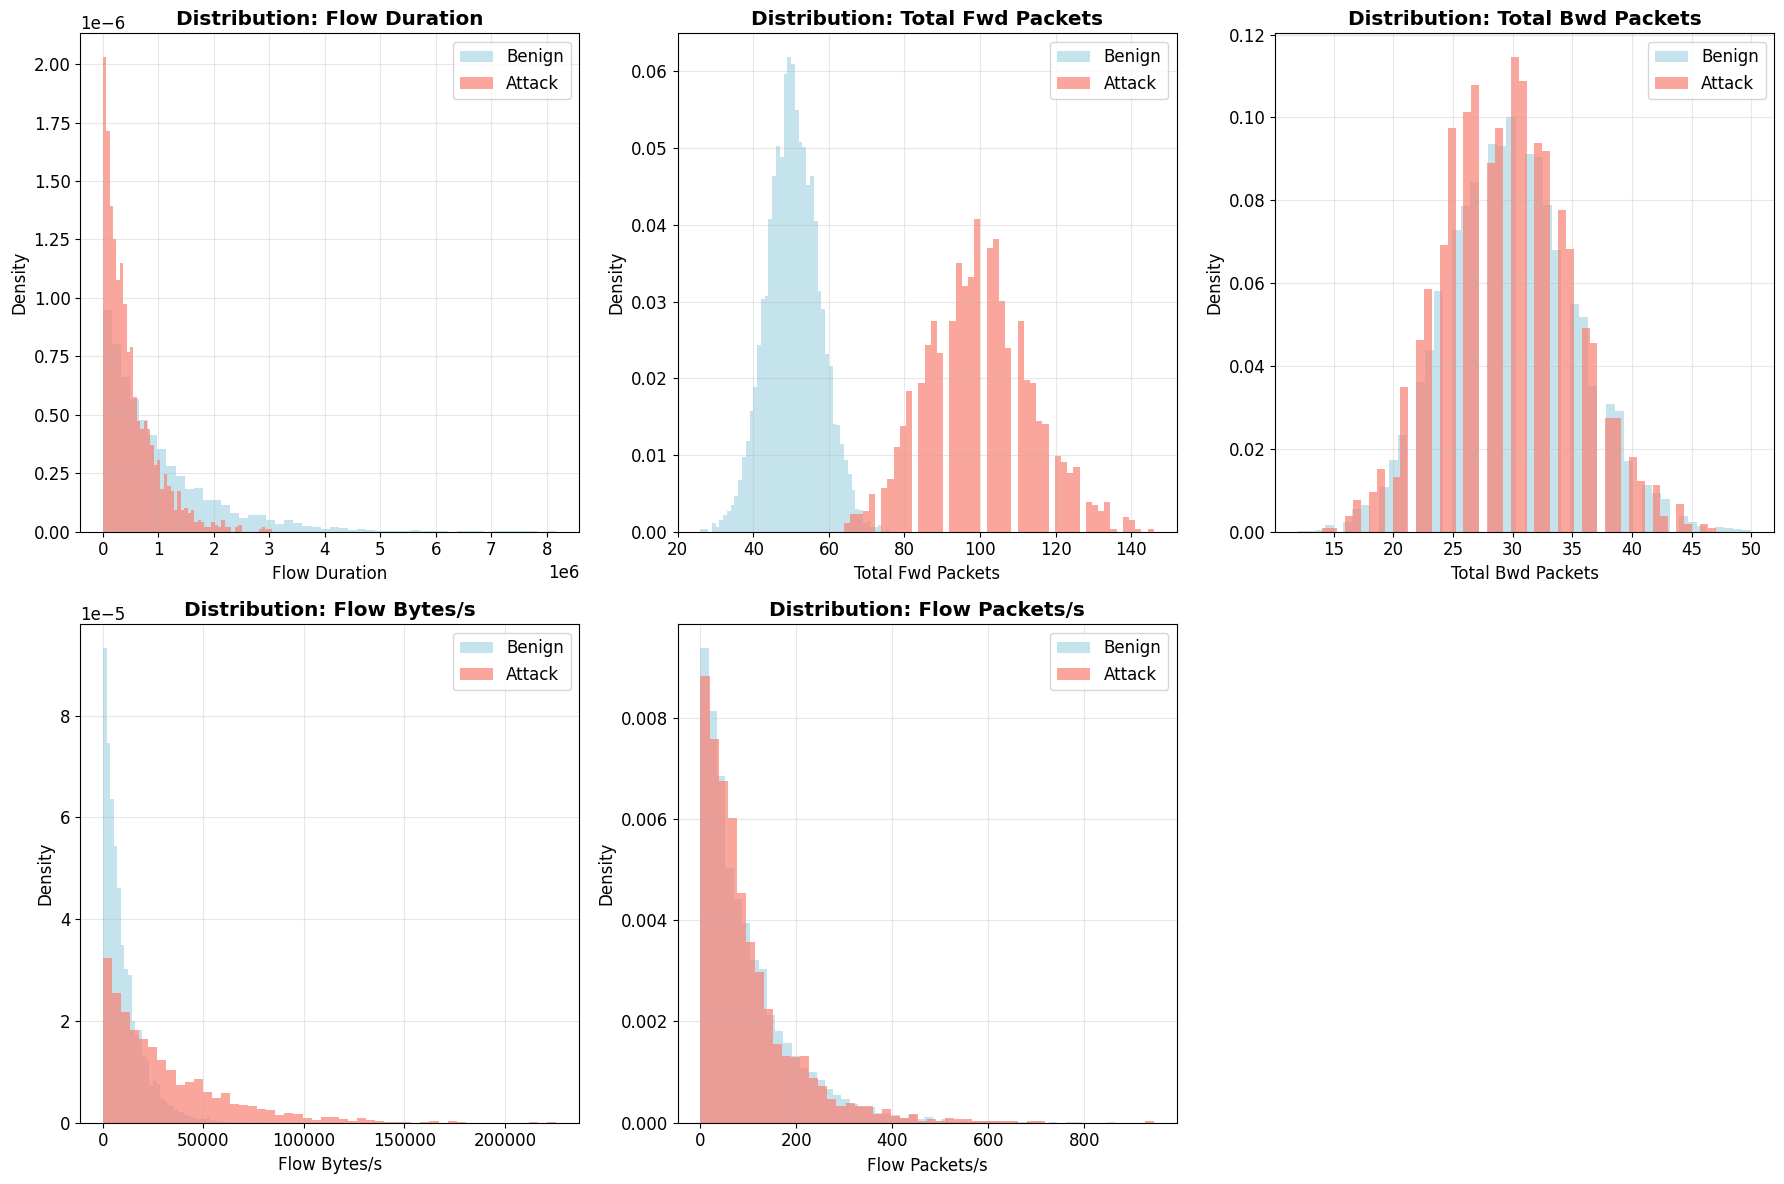

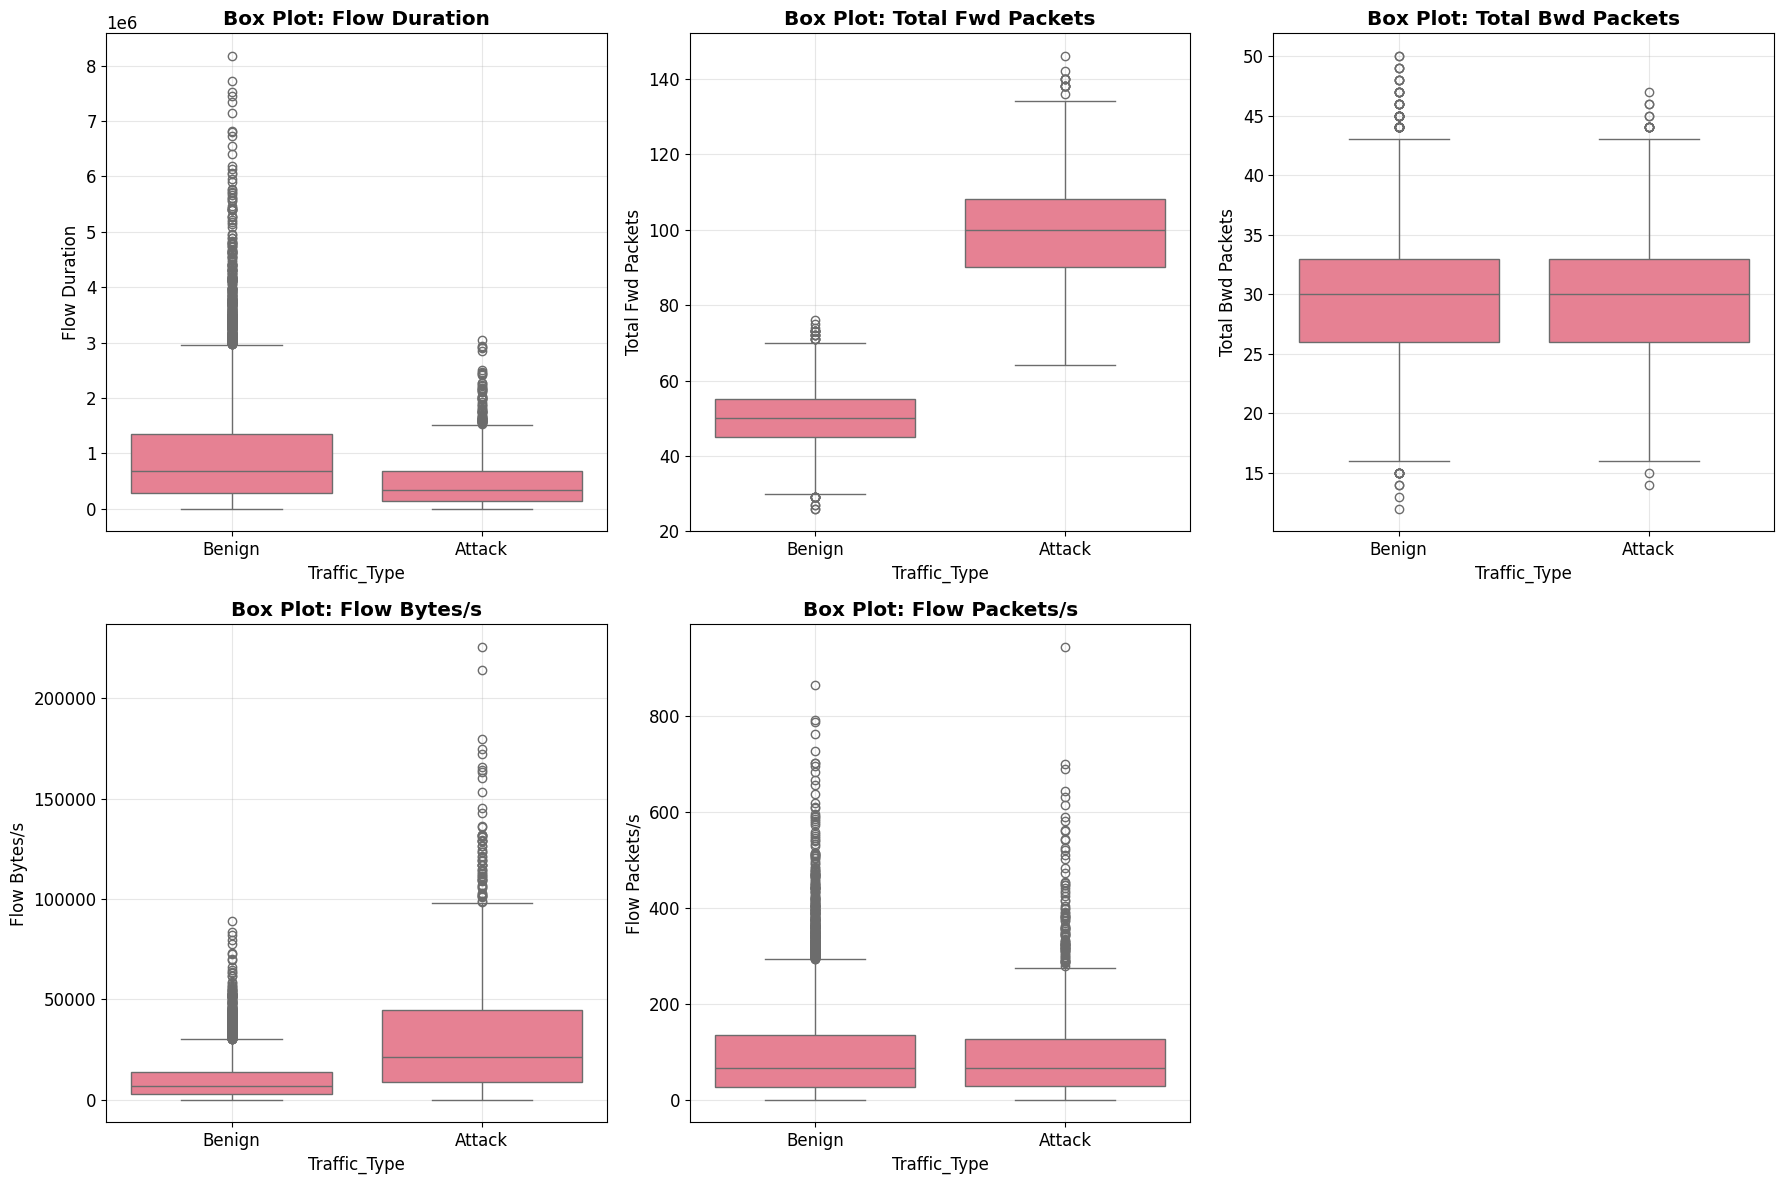

In [6]:
# Statistical summary of numerical features
print("Statistical Summary of Key Features:")
print("=" * 60)
key_features = ['Flow Duration', 'Total Fwd Packets', 'Total Bwd Packets', 
                'Flow Bytes/s', 'Flow Packets/s']
display(df[key_features].describe())

# Visualize distributions of key features
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(key_features):
    # Create histogram with benign vs attack comparison
    benign_data = df[df['Label'] == 'BENIGN'][feature]
    attack_data = df[df['Label'] != 'BENIGN'][feature]
    
    axes[i].hist(benign_data, bins=50, alpha=0.7, label='Benign', color='lightblue', density=True)
    axes[i].hist(attack_data, bins=50, alpha=0.7, label='Attack', color='salmon', density=True)
    axes[i].set_title(f'Distribution: {feature}', fontweight='bold')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

# Remove empty subplot
axes[-1].remove()

plt.tight_layout()
plt.show()

# Box plots for comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, feature in enumerate(key_features):
    # Create binary labels for visualization
    df_viz = df.copy()
    df_viz['Traffic_Type'] = df_viz['Label'].apply(lambda x: 'Benign' if x == 'BENIGN' else 'Attack')
    
    sns.boxplot(data=df_viz, x='Traffic_Type', y=feature, ax=axes[i])
    axes[i].set_title(f'Box Plot: {feature}', fontweight='bold')
    axes[i].grid(True, alpha=0.3)

# Remove empty subplot
axes[-1].remove()

plt.tight_layout()
plt.show()

## Step 2: Data Cleaning and Feature Selection

Now let's prepare our data for machine learning by:
1. Handling missing or infinite values
2. Removing highly correlated features
3. Selecting the most relevant features
4. Normalizing the data

In [7]:
# Check for missing values and infinite values
print("Data Quality Check:")
print("=" * 40)

# Separate features and labels
features = df.drop('Label', axis=1)
labels = df['Label']

print(f"Missing values per column:")
missing_counts = features.isnull().sum()
print(missing_counts[missing_counts > 0] if missing_counts.sum() > 0 else "No missing values found")

print(f"\nInfinite values per column:")
inf_counts = features.apply(lambda x: np.isinf(x).sum())
print(inf_counts[inf_counts > 0] if inf_counts.sum() > 0 else "No infinite values found")

# Handle any infinite values by replacing with NaN, then fill with column median
features_clean = features.replace([np.inf, -np.inf], np.nan)
if features_clean.isnull().sum().sum() > 0:
    features_clean = features_clean.fillna(features_clean.median())
    print("Infinite values replaced with column medians")

# Check data types
print(f"\nData types:")
print(features_clean.dtypes.value_counts())

print(f"\nCleaned dataset shape: {features_clean.shape}")

Data Quality Check:
Missing values per column:
No missing values found

Infinite values per column:
No infinite values found

Data types:
float64    25
int64       6
Name: count, dtype: int64

Cleaned dataset shape: (8000, 31)


Correlation Analysis:
Found 0 highly correlated feature pairs (|r| > 0.95):

Removed 0 highly correlated features
Features after correlation filtering: 31


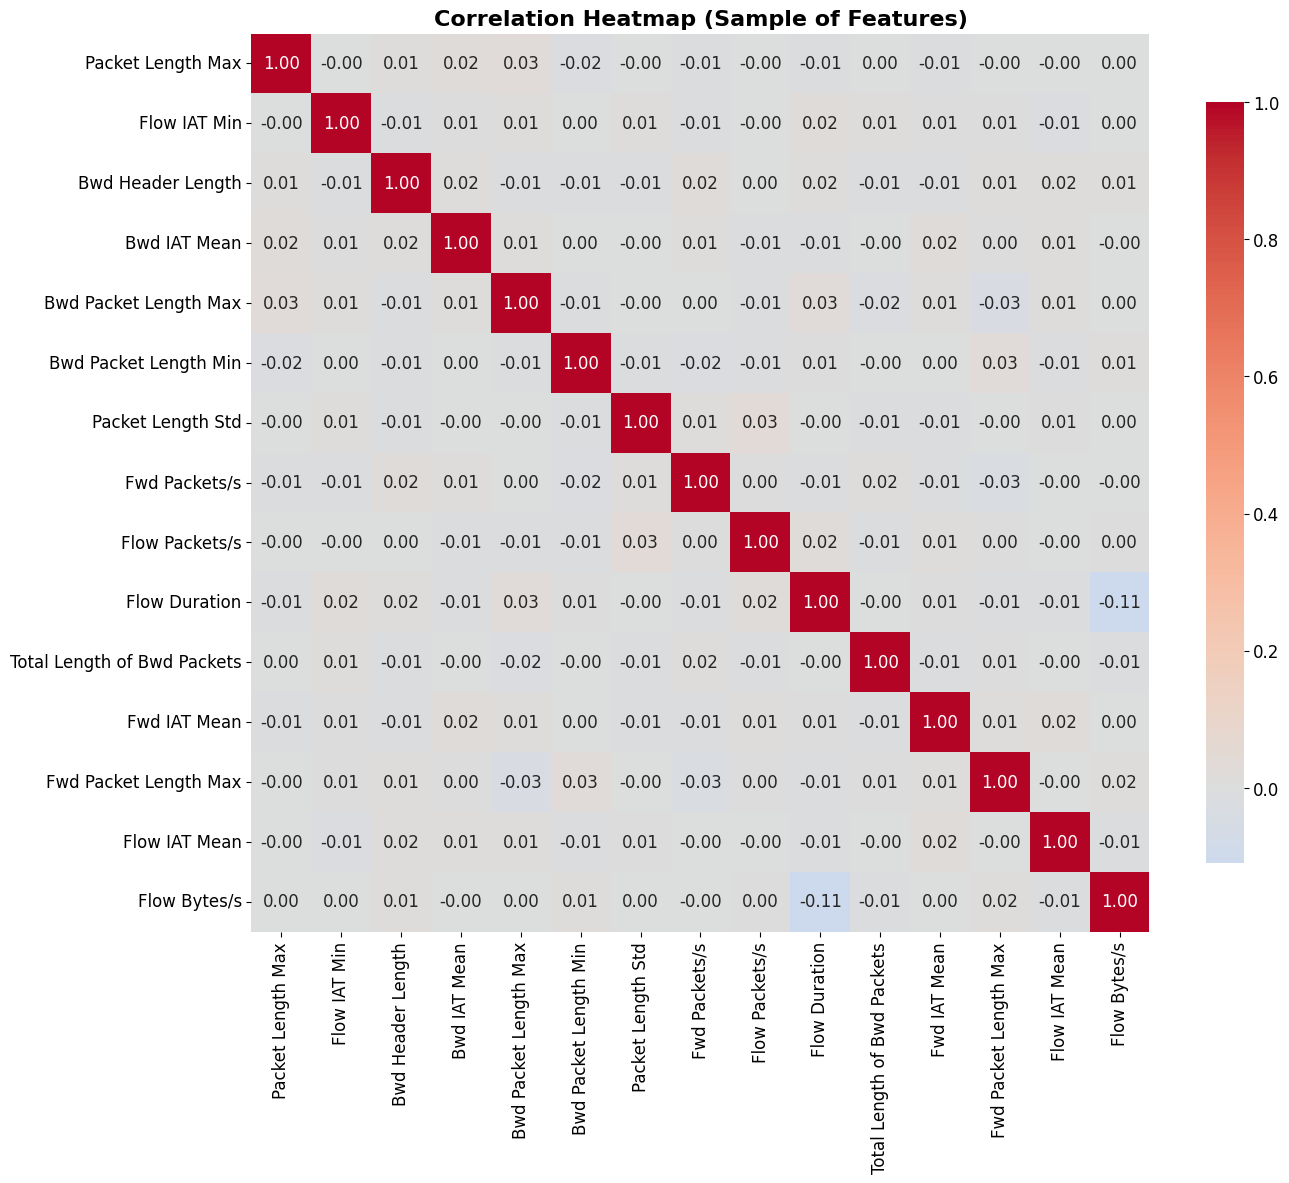

In [8]:
# Correlation analysis
print("Correlation Analysis:")
print("=" * 30)

# Calculate correlation matrix
correlation_matrix = features_clean.corr()

# Find highly correlated feature pairs (threshold > 0.95)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.95:
            high_corr_pairs.append((
                correlation_matrix.columns[i], 
                correlation_matrix.columns[j], 
                correlation_matrix.iloc[i, j]
            ))

print(f"Found {len(high_corr_pairs)} highly correlated feature pairs (|r| > 0.95):")
for feat1, feat2, corr in high_corr_pairs[:5]:  # Show first 5
    print(f"• {feat1} ↔ {feat2}: {corr:.3f}")

# Remove highly correlated features (keep one from each pair)
features_to_remove = set()
for feat1, feat2, corr in high_corr_pairs:
    features_to_remove.add(feat2)  # Remove the second feature

features_selected = features_clean.drop(columns=list(features_to_remove))
print(f"\nRemoved {len(features_to_remove)} highly correlated features")
print(f"Features after correlation filtering: {features_selected.shape[1]}")

# Plot correlation heatmap for remaining features (sample if too many)
plt.figure(figsize=(14, 12))
if features_selected.shape[1] > 20:
    # Sample features for visualization
    sample_features = features_selected.sample(n=15, axis=1, random_state=42)
    sns.heatmap(sample_features.corr(), annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.2f', cbar_kws={'shrink': .8})
    plt.title('Correlation Heatmap (Sample of Features)', fontsize=16, fontweight='bold')
else:
    sns.heatmap(features_selected.corr(), annot=True, cmap='coolwarm', center=0, 
                square=True, fmt='.2f', cbar_kws={'shrink': .8})
    plt.title('Correlation Heatmap (All Features)', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

## Step 3: Label Encoding

Convert our categorical labels into binary format suitable for machine learning models.

Converting Labels to Binary Format:
Original label distribution:
Label
BENIGN         6400
DDoS            351
DoS Hulk        330
PortScan        309
SSH-Patator     308
FTP-Patator     302
Name: count, dtype: int64

Binary label distribution:
0 (Benign): 6400
1 (Attack): 1600

Percentages:
• Benign: 80.0%
• Attack: 20.0%


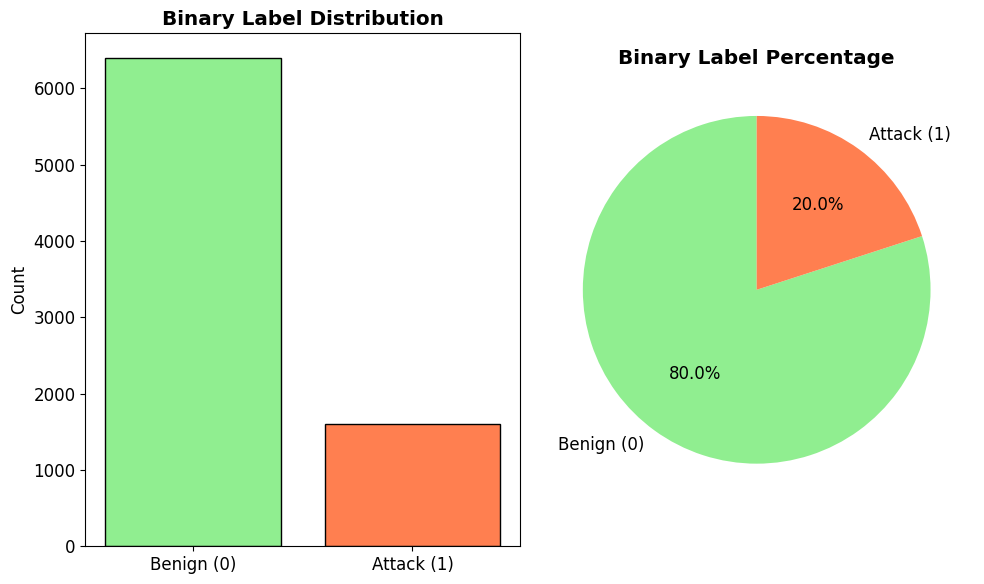


Labels successfully converted to binary format
Final dataset shape: 8000 samples × 31 features


In [9]:
# Convert labels to binary format
print("Converting Labels to Binary Format:")
print("=" * 45)

# Create binary labels: 0 = BENIGN, 1 = ATTACK
binary_labels = (labels != 'BENIGN').astype(int)

print("Original label distribution:")
print(labels.value_counts())

print("\nBinary label distribution:")
print("0 (Benign):", (binary_labels == 0).sum())
print("1 (Attack):", (binary_labels == 1).sum())

# Calculate percentages
benign_pct = (binary_labels == 0).mean() * 100
attack_pct = (binary_labels == 1).mean() * 100

print(f"\nPercentages:")
print(f"• Benign: {benign_pct:.1f}%")
print(f"• Attack: {attack_pct:.1f}%")

# Visualize binary distribution
plt.figure(figsize=(10, 6))
counts = [sum(binary_labels == 0), sum(binary_labels == 1)]
labels_viz = ['Benign (0)', 'Attack (1)']
colors = ['lightgreen', 'coral']

plt.subplot(1, 2, 1)
plt.bar(labels_viz, counts, color=colors, edgecolor='black')
plt.title('Binary Label Distribution', fontweight='bold')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.pie(counts, labels=labels_viz, autopct='%1.1f%%', colors=colors, startangle=90)
plt.title('Binary Label Percentage', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nLabels successfully converted to binary format")
print(f"Final dataset shape: {features_selected.shape[0]} samples × {features_selected.shape[1]} features")

## Step 4: Feature Importance Analysis

Let's identify which features are most important for distinguishing between benign and malicious traffic using Random Forest feature importance and mutual information.

Random Forest Feature Importance Analysis:
Top 10 most important features (Random Forest):
                        feature  importance
1             Total Fwd Packets    0.794979
11                 Flow Bytes/s    0.089650
0                 Flow Duration    0.024663
28           Packet Length Mean    0.004526
6         Fwd Packet Length Min    0.004350
3   Total Length of Fwd Packets    0.004238
5         Fwd Packet Length Max    0.004174
30       Packet Length Variance    0.004095
27            Packet Length Max    0.004047
15                 Flow IAT Min    0.003963

Mutual Information Analysis:
Top 10 most important features (Random Forest):
                        feature  importance
1             Total Fwd Packets    0.794979
11                 Flow Bytes/s    0.089650
0                 Flow Duration    0.024663
28           Packet Length Mean    0.004526
6         Fwd Packet Length Min    0.004350
3   Total Length of Fwd Packets    0.004238
5         Fwd Packet Length Max    0.00

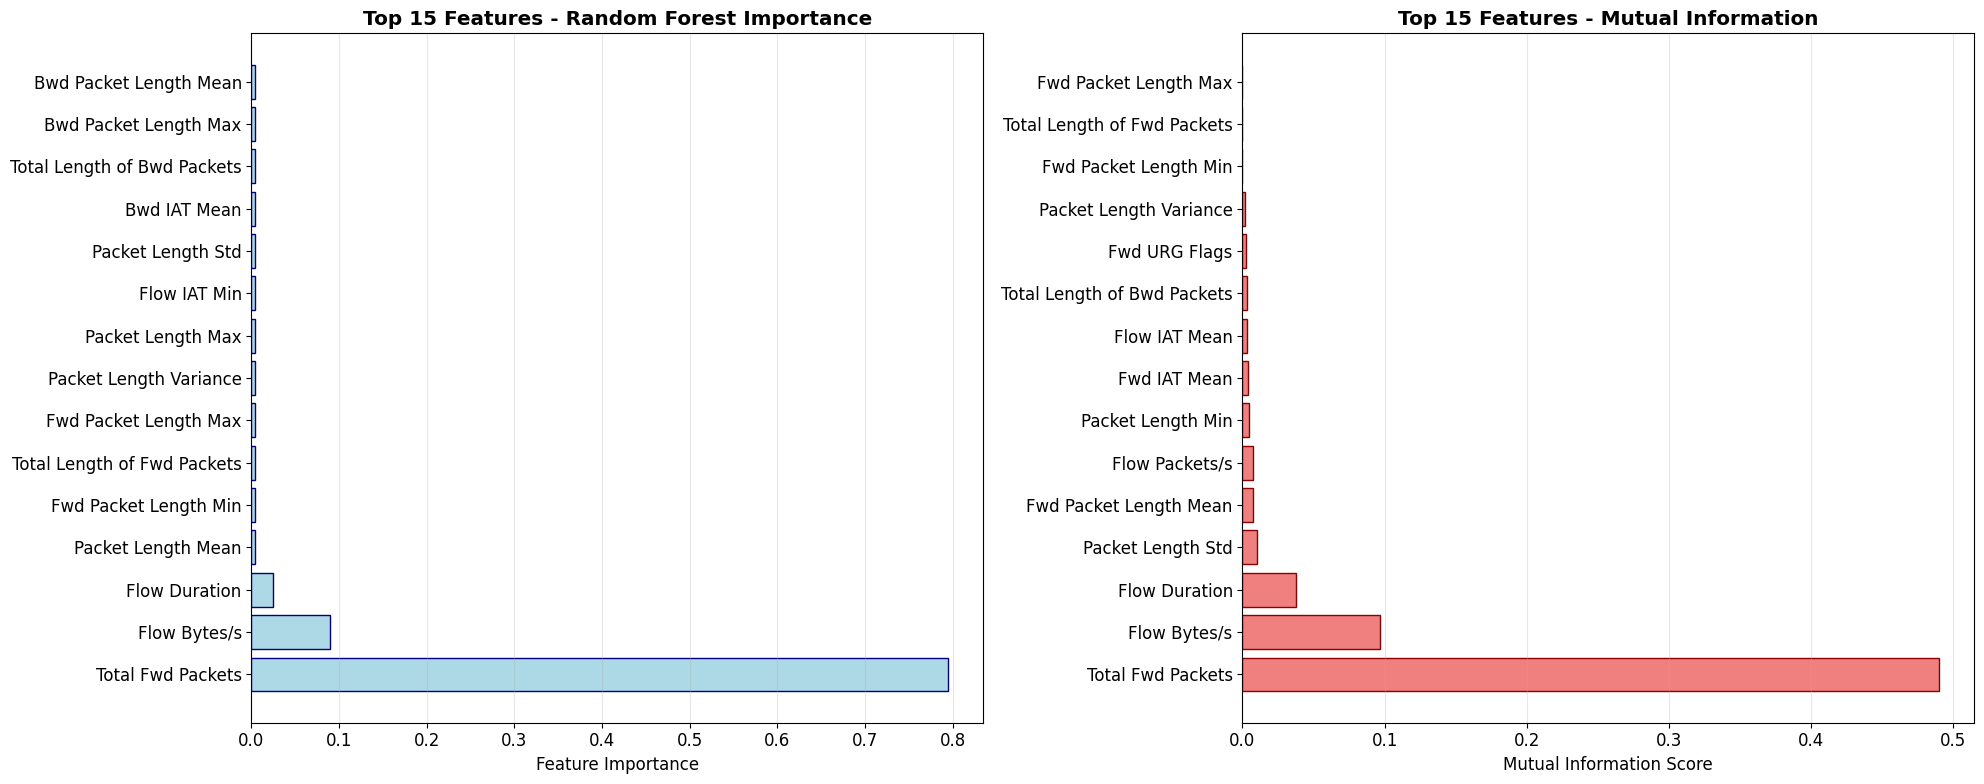


Selected 21 top features for final dataset
Selected features: ['Packet Length Max', 'Flow Packets/s', 'Packet Length Min', 'Flow IAT Min', 'Bwd Packet Length Mean', 'Fwd Packet Length Max', 'Fwd IAT Mean', 'Total Fwd Packets', 'Flow Duration', 'Total Length of Fwd Packets'] ...


In [10]:
# Feature importance using Random Forest
print("Random Forest Feature Importance Analysis:")
print("=" * 50)

# Train a quick Random Forest for feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(features_selected, binary_labels)

# Get feature importance
rf_importance = pd.DataFrame({
    'feature': features_selected.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 most important features (Random Forest):")
print(rf_importance.head(10))

# Mutual Information feature importance
print("\nMutual Information Analysis:")
print("=" * 35)

mi_scores = mutual_info_classif(features_selected, binary_labels, random_state=42)
mi_importance = pd.DataFrame({
    'feature': features_selected.columns,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

print("Top 10 most important features (Mutual Information):")
print(mi_importance.head(10))

# Visualize feature importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Random Forest importance
top_rf = rf_importance.head(15)
ax1.barh(range(len(top_rf)), top_rf['importance'], color='lightblue', edgecolor='navy')
ax1.set_yticks(range(len(top_rf)))
ax1.set_yticklabels(top_rf['feature'])
ax1.set_xlabel('Feature Importance')
ax1.set_title('Top 15 Features - Random Forest Importance', fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# Mutual Information
top_mi = mi_importance.head(15)
ax2.barh(range(len(top_mi)), top_mi['mi_score'], color='lightcoral', edgecolor='darkred')
ax2.set_yticks(range(len(top_mi)))
ax2.set_yticklabels(top_mi['feature'])
ax2.set_xlabel('Mutual Information Score')
ax2.set_title('Top 15 Features - Mutual Information', fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# Select top features based on both methods
top_rf_features = set(rf_importance.head(15)['feature'])
top_mi_features = set(mi_importance.head(15)['feature'])  # Fixed: use 'feature' not 'mi_score'
top_features = list(top_rf_features.union(top_mi_features))

print(f"\nSelected {len(top_features)} top features for final dataset")
print("Selected features:", top_features[:10], "..." if len(top_features) > 10 else "")

Data Normalization:
Normalized 21 features
Final feature statistics:
       Packet Length Max  Flow Packets/s  Packet Length Min  Flow IAT Min  \
count       8.000000e+03    8.000000e+03       8.000000e+03  8.000000e+03   
mean        1.016964e-16    1.039169e-16      -5.062617e-17 -3.552714e-18   
std         1.000063e+00    1.000063e+00       1.000063e+00  1.000063e+00   
min        -9.938957e-01   -9.892797e-01      -9.874985e-01 -1.012893e+00   
25%        -7.123415e-01   -7.053376e-01      -7.073449e-01 -7.234099e-01   
50%        -3.052557e-01   -3.082118e-01      -3.123339e-01 -3.063129e-01   
75%         3.760022e-01    3.637194e-01       3.702113e-01  4.062036e-01   
max         7.669818e+00    8.606367e+00       8.261041e+00  7.623148e+00   

       Bwd Packet Length Mean  Fwd Packet Length Max  Fwd IAT Mean  \
count            8.000000e+03           8.000000e+03  8.000000e+03   
mean             1.914024e-16          -1.199041e-17  4.751755e-17   
std              1.000063e+

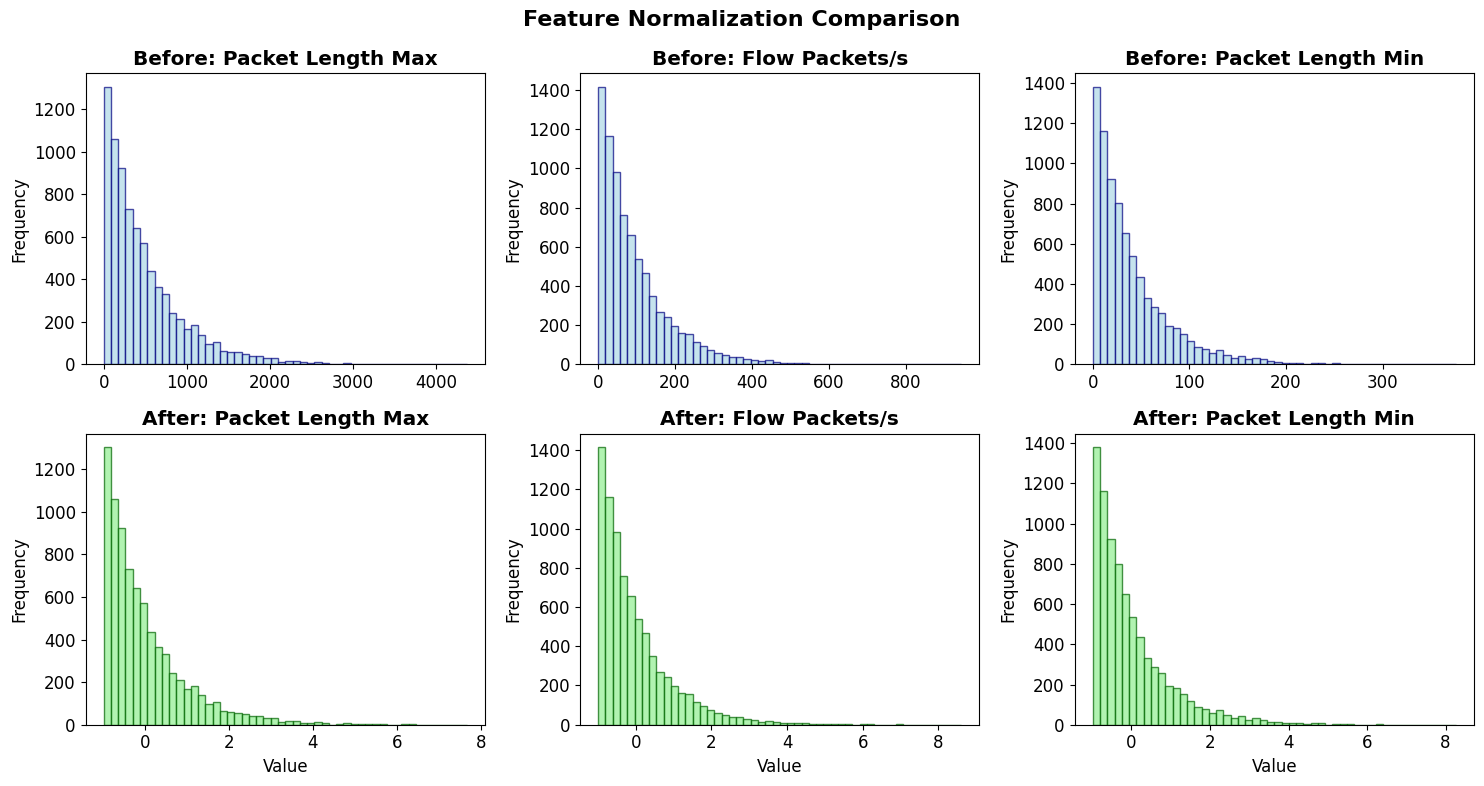


Data preprocessing completed successfully!


In [11]:
# Select final features and normalize
print("Data Normalization:")
print("=" * 25)

# Select top features
final_features = features_selected[top_features]

# Standardize features
scaler = StandardScaler()
features_normalized = scaler.fit_transform(final_features)
features_normalized_df = pd.DataFrame(features_normalized, columns=final_features.columns)

print(f"Normalized {features_normalized_df.shape[1]} features")
print(f"Final feature statistics:")
print(features_normalized_df.describe())

# Show before/after normalization comparison for a few features
sample_features = final_features.columns[:3]
fig, axes = plt.subplots(2, len(sample_features), figsize=(15, 8))

for i, feature in enumerate(sample_features):
    # Before normalization
    axes[0, i].hist(final_features[feature], bins=50, alpha=0.7, color='lightblue', edgecolor='navy')
    axes[0, i].set_title(f'Before: {feature}', fontweight='bold')
    axes[0, i].set_ylabel('Frequency')
    
    # After normalization
    axes[1, i].hist(features_normalized_df[feature], bins=50, alpha=0.7, color='lightgreen', edgecolor='darkgreen')
    axes[1, i].set_title(f'After: {feature}', fontweight='bold')
    axes[1, i].set_ylabel('Frequency')
    axes[1, i].set_xlabel('Value')

plt.suptitle('Feature Normalization Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nData preprocessing completed successfully!")

## Step 5: Data Export

Save our cleaned and preprocessed dataset for use in the next module where we'll build lightweight ML models for edge-based anomaly detection.

In [12]:
# Create final dataset combining features and labels
final_dataset = features_normalized_df.copy()
final_dataset['Label'] = binary_labels.values

print("Final Dataset Summary:")
print("=" * 30)
print(f"Shape: {final_dataset.shape}")
print(f"Features: {final_dataset.shape[1] - 1}")
print(f"Samples: {final_dataset.shape[0]:,}")
print(f"\nMemory usage: {final_dataset.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print(f"\nClass distribution in final dataset:")
print(f"• Benign (0): {(final_dataset['Label'] == 0).sum():,} ({(final_dataset['Label'] == 0).mean()*100:.1f}%)")
print(f"• Attack (1): {(final_dataset['Label'] == 1).sum():,} ({(final_dataset['Label'] == 1).mean()*100:.1f}%)")

# Display sample of final dataset
print("\nSample of Final Dataset:")
display(final_dataset.head())

# Save to CSV
import os
os.makedirs('data', exist_ok=True)
output_file = 'data/cleaned_network_traffic.csv'
final_dataset.to_csv(output_file, index=False)

print(f"\nDataset saved to: {output_file}")
print(f"Ready for edge AI model development!")

# Also save feature names and scaler for future use
import pickle
with open('data/feature_names.pkl', 'wb') as f:
    pickle.dump(list(features_normalized_df.columns), f)
    
with open('data/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Saved feature names and scaler for future model deployment")

Final Dataset Summary:
Shape: (8000, 22)
Features: 21
Samples: 8,000

Memory usage: 1.34 MB

Class distribution in final dataset:
• Benign (0): 6,400 (80.0%)
• Attack (1): 1,600 (20.0%)

Sample of Final Dataset:


,Packet Length Max,Flow Packets/s,Packet Length Min,Flow IAT Min,Bwd Packet Length Mean,Fwd Packet Length Max,Fwd IAT Mean,Total Fwd Packets,Flow Duration,Total Length of Fwd Packets,...,Flow Bytes/s,Bwd IAT Mean,Bwd Packet Length Max,Flow IAT Mean,Packet Length Mean,Fwd Packet Length Min,Fwd Packet Length Mean,Total Length of Bwd Packets,Fwd URG Flags,Label
0,-0.705842,0.965962,-0.973035,0.972095,-0.972177,-0.911699,-0.008439,-0.233751,-0.446111,-0.665058,...,0.242424,-0.675235,-0.902005,-0.805201,1.529141,-0.078828,-0.762265,-0.779604,-0.233909,0
1,-0.040499,1.154297,0.309477,-0.823790,-0.360669,1.021043,-0.792985,-0.417912,2.267655,0.229961,...,-0.475483,0.549596,0.993663,0.467964,-0.800601,0.080681,-0.723202,2.759887,-0.233909,0
2,-0.534369,0.769411,-0.437090,-0.593673,0.029592,-0.312350,2.739710,-0.187711,0.459040,-0.062969,...,0.056139,-0.784943,0.192275,-0.366947,-0.422054,0.256822,-0.852776,-0.419435,-0.233909,0
3,-0.675800,-0.153825,-0.763846,-0.689974,-0.911294,0.092764,-0.920774,2.206375,-0.459778,-0.389670,...,-0.477819,-0.190520,-0.858034,-0.763101,-0.771351,-0.676297,-0.679546,-0.767539,-0.233909,1
4,-0.649827,1.805566,-0.820249,-0.879337,-0.059051,0.720733,-0.181451,2.574696,-0.856730,-0.526814,...,5.079206,-0.441907,-0.681326,-0.935556,1.067608,-0.333406,0.565306,-0.549520,-0.233909,1



Dataset saved to: data/cleaned_network_traffic.csv
Ready for edge AI model development!
Saved feature names and scaler for future model deployment
